In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [11]:
file_path = "/content/drive/MyDrive/Coimbatore_AQIBulletins.csv"

In [12]:
try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

In [13]:
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Initial shape: (841, 6)
Columns: ['date', 'City', 'No. Stations', 'Air Quality', 'Index Value', 'Prominent Pollutant']


,date,City,No. Stations,Air Quality,Index Value,Prominent Pollutant
0,2019-06-14,Coimbatore,1.0,Satisfactory,59,CO
1,2019-06-15,Coimbatore,1.0,Satisfactory,58,CO
2,2019-06-16,Coimbatore,1.0,Satisfactory,55,CO
3,2019-06-17,Coimbatore,1.0,Satisfactory,61,CO
4,2019-06-18,Coimbatore,1.0,Satisfactory,81,PM2.5


In [14]:
col_map = {}
cols = [c.lower().strip() for c in df.columns]

date_candidates = [c for c in df.columns if any(x in c.lower() for x in ['date', 'datetime', 'day'])]
if date_candidates:
    col_map['date'] = date_candidates[0]
else:
    raise ValueError("No date column found. Please ensure the CSV has a Date / Datetime column.")

index_candidates = [c for c in df.columns if any(x in c.lower() for x in ['index', 'aqi', 'index value', 'index_value'])]
if index_candidates:
    col_map['index'] = index_candidates[0]
else:
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numeric_cols) >= 1:
        col_map['index'] = numeric_cols[0]
    else:
        raise ValueError("No numeric Index/AQI column found.")

pollutant_candidates = [c for c in df.columns if 'pollut' in c.lower() or 'prominent' in c.lower() or 'main' in c.lower()]
col_map['pollutant'] = pollutant_candidates[0] if pollutant_candidates else None

print("Column mapping chosen:", col_map)


df_work = df.copy()

df_work[col_map['date']] = pd.to_datetime(df_work[col_map['date']], errors='coerce')
df_work = df_work.dropna(subset=[col_map['date']])
df_work = df_work.sort_values(by=col_map['date']).reset_index(drop=True)


df_work = df_work.rename(columns={col_map['date']:'date', col_map['index']:'index_value'})
if col_map['pollutant']:
    df_work = df_work.rename(columns={col_map['pollutant']:'prominent_pollutant'})
else:
    df_work['prominent_pollutant'] = np.nan

df_work['index_value'] = pd.to_numeric(df_work['index_value'], errors='coerce')

print("After normalization, columns:", df_work.columns.tolist())
df_work.head()


Column mapping chosen: {'date': 'date', 'index': 'Index Value', 'pollutant': 'Prominent Pollutant'}
After normalization, columns: ['date', 'City', 'No. Stations', 'Air Quality', 'index_value', 'prominent_pollutant']


,date,City,No. Stations,Air Quality,index_value,prominent_pollutant
0,2019-06-14,Coimbatore,1.0,Satisfactory,59,CO
1,2019-06-15,Coimbatore,1.0,Satisfactory,58,CO
2,2019-06-16,Coimbatore,1.0,Satisfactory,55,CO
3,2019-06-17,Coimbatore,1.0,Satisfactory,61,CO
4,2019-06-18,Coimbatore,1.0,Satisfactory,81,PM2.5


In [ ]:
#TASK 1

Missing index_value: 0


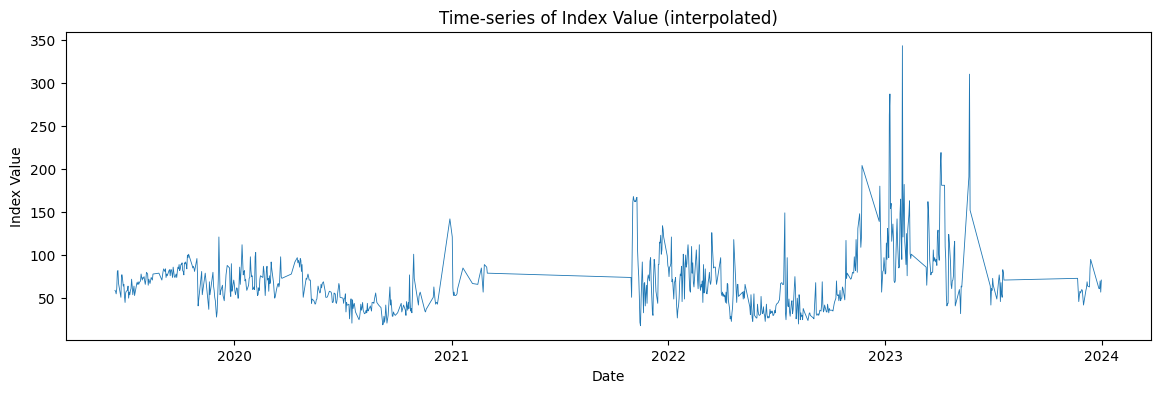

Abnormal readings (|z|>3): 16


,date,index_value,index_value_interp,zscore
695,2022-11-23,204,204,3.792521
697,2022-12-23,180,180,3.116067
713,2023-01-08,263,263,5.455471
714,2023-01-09,287,287,6.131925
734,2023-01-30,343,343,7.710318
736,2023-02-02,182,182,3.172438
771,2023-04-04,205,205,3.820706
772,2023-04-05,219,219,4.215305
773,2023-04-06,181,181,3.144252
774,2023-04-07,181,181,3.144252


In [15]:

print("Missing index_value:", df_work['index_value'].isna().sum())


df_work['index_value_interp'] = df_work['index_value'].interpolate(method='time')


plt.figure(figsize=(14,4))
plt.plot(df_work['date'], df_work['index_value_interp'], lw=0.6)
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("Time-series of Index Value (interpolated)")
plt.show()

from scipy import stats
df_work['zscore'] = stats.zscore(df_work['index_value_interp'].fillna(method='ffill'))
abnormal = df_work[np.abs(df_work['zscore']) > 3]
print("Abnormal readings (|z|>3):", len(abnormal))
abnormal[['date','index_value','index_value_interp','zscore']].head(10)


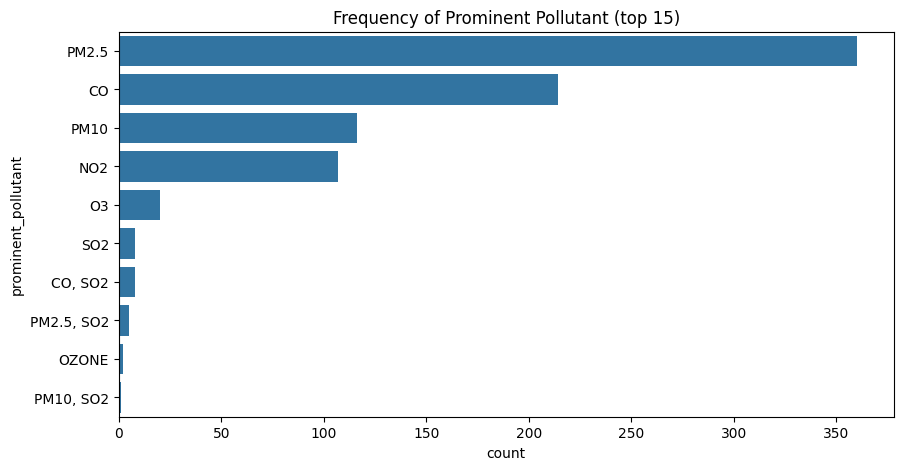

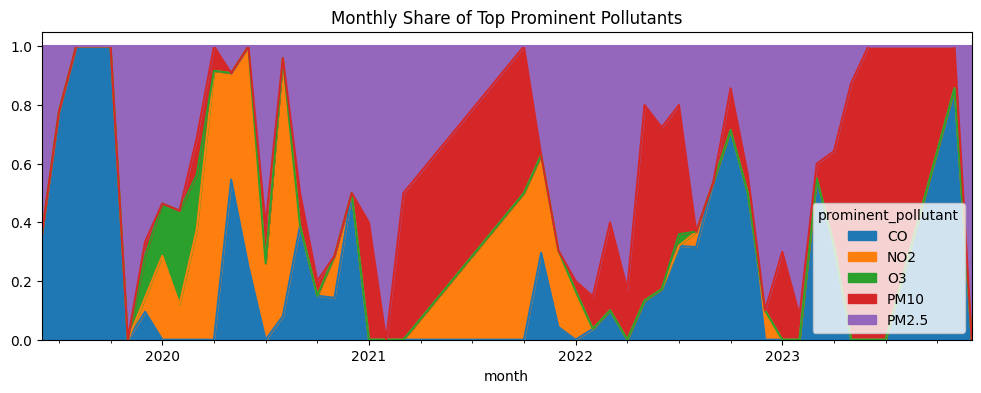

In [16]:

if df_work['prominent_pollutant'].notna().sum() > 0:
    df_work['prominent_pollutant'] = df_work['prominent_pollutant'].astype(str)
    plt.figure(figsize=(10,5))
    sns.countplot(y=df_work['prominent_pollutant'], order=df_work['prominent_pollutant'].value_counts().index[:15])
    plt.title("Frequency of Prominent Pollutant (top 15)")
    plt.show()

    top_p = df_work['prominent_pollutant'].value_counts().index[:5].tolist()
    df_top = df_work[df_work['prominent_pollutant'].isin(top_p)].copy()
    df_top['month'] = df_top['date'].dt.to_period('M')
    poll_month = df_top.groupby(['month','prominent_pollutant']).size().unstack(fill_value=0)
    poll_month = poll_month.div(poll_month.sum(axis=1), axis=0)
    poll_month.plot(kind='area', figsize=(12,4), stacked=True)
    plt.title("Monthly Share of Top Prominent Pollutants")
    plt.show()
else:
    print("No pollutant data available to visualize.")


In [ ]:
#TASK 2

In [17]:
daily = df_work.set_index('date')['index_value_interp'].resample('D').mean().rename('index_daily')
daily = daily.dropna()
print("Daily length:", len(daily))
daily.head()


window_days = 7

def create_windowed(series, window=7):
    X, y, dates = [], [], []
    arr = series.values
    idx = series.index
    for i in range(window, len(arr)):
        X.append(arr[i-window:i])
        y.append(arr[i])
        dates.append(idx[i])
    return np.array(X), np.array(y), np.array(dates)

X, y, dates = create_windowed(daily, window_days)
print("X shape:", X.shape, "y shape:", y.shape)


Daily length: 841
X shape: (834, 7) y shape: (834,)


In [18]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = dates[split:]

scaler = MinMaxScaler()
X_train_flat = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_flat = scaler.transform(X_test.reshape(X_test.shape[0], -1))

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_flat, y_train)
y_pred = rf.predict(X_test_flat)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("MAE:", round(mae,4), "RMSE:", round(rmse,4))


MAE: 23.6205 RMSE: 40.6583


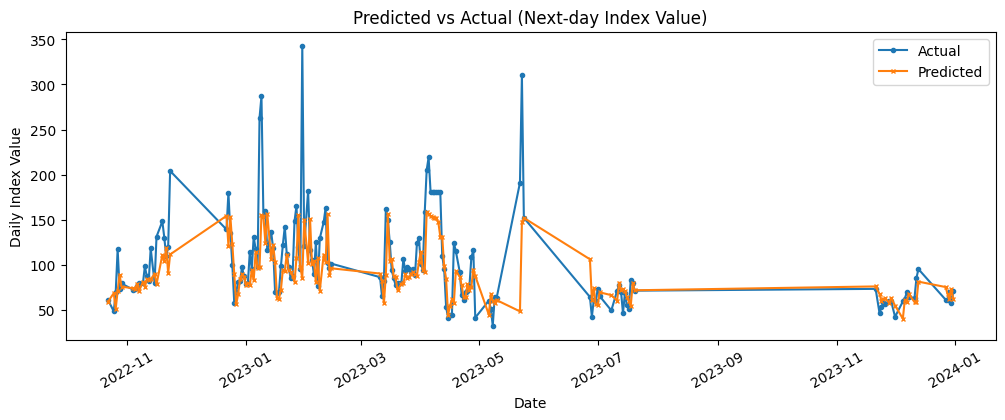

In [19]:
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test, label='Actual', marker='o', markersize=3)
plt.plot(dates_test, y_pred, label='Predicted', marker='x', markersize=3)
plt.xlabel("Date")
plt.ylabel("Daily Index Value")
plt.title("Predicted vs Actual (Next-day Index Value)")
plt.legend()
plt.xticks(rotation=30)
plt.show()


In [ ]:
#TASK 3

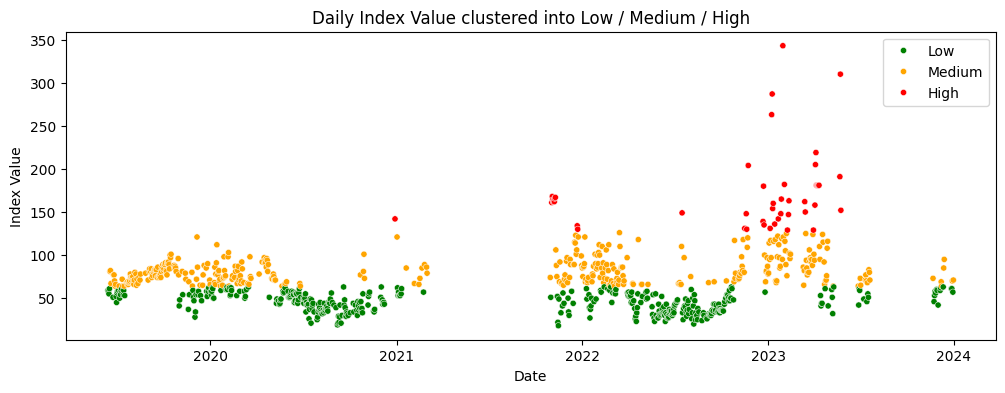

,cluster_label,count,min,mean,max
0,High,48,129.0,171.812500,343.0
1,Low,408,18.0,44.723039,63.0
2,Medium,385,64.0,82.880519,126.0


In [20]:
daily_df = daily.to_frame().reset_index().rename(columns={'date':'date','index_daily':'index_value'})
X_cluster = daily_df[['index_value']].values

kmeans = KMeans(n_clusters=3, random_state=42)
daily_df['cluster'] = kmeans.fit_predict(X_cluster)

centers = kmeans.cluster_centers_.flatten()
ordered = np.argsort(centers)
label_map = { ordered[0]: 'Low', ordered[1]:'Medium', ordered[2]:'High' }
daily_df['cluster_label'] = daily_df['cluster'].map(label_map)


plt.figure(figsize=(12,4))
sns.scatterplot(x='date', y='index_value', hue='cluster_label', data=daily_df, palette=['green','orange','red'], s=20)
plt.title("Daily Index Value clustered into Low / Medium / High")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()

summary = daily_df.groupby('cluster_label')['index_value'].agg(['count','min','mean','max']).reset_index()
summary


In [ ]:
#TASK 4

In [21]:
monthly = daily_df.set_index('date')['index_value'].resample('M').mean().rename('monthly_avg').to_frame().reset_index()
monthly['month_str'] = monthly['date'].dt.strftime('%Y-%m')


q_low, q_high = monthly['monthly_avg'].quantile([0.33, 0.66]).values
def month_category(avg):
    if avg <= q_low:
        return 'Clean'
    elif avg <= q_high:
        return 'Moderate'
    else:
        return 'High'

monthly['category'] = monthly['monthly_avg'].apply(month_category)


print("Quantile thresholds:", round(q_low,3), round(q_high,3))
monthly[['month_str','monthly_avg','category']].head(15)


Quantile thresholds: 59.436 72.819


,month_str,monthly_avg,category
0,2019-06,65.714286,Moderate
1,2019-07,63.037037,Moderate
2,2019-08,72.785714,Moderate
3,2019-09,79.720000,High
4,2019-10,87.739130,High
5,2019-11,59.714286,Moderate
6,2019-12,65.619048,Moderate
7,2020-01,71.714286,Moderate
8,2020-02,70.240000,Moderate
9,2020-03,69.312500,Moderate


In [22]:
high_months = monthly[monthly['category']=='High']['month_str'].tolist()
clean_months = monthly[monthly['category']=='Clean']['month_str'].tolist()

insight = f"Seasonal Insight:\n- Months consistently high pollution: {', '.join(high_months[:6]) or 'None'}\n"
insight += f"- Months categorized Clean: {', '.join(clean_months[:6]) or 'None'}\n"
insight += "Recommendation: For months with high pollution, advise stricter controls on combustion sources and issuing health advisories; for moderate months, target mitigation actions during high-peak days."

print(insight)


Seasonal Insight:
- Months consistently high pollution: 2019-09, 2019-10, 2020-04, 2021-02, 2021-03, 2021-04
- Months categorized Clean: 2020-06, 2020-07, 2020-08, 2020-09, 2020-10, 2020-11
Recommendation: For months with high pollution, advise stricter controls on combustion sources and issuing health advisories; for moderate months, target mitigation actions during high-peak days.
